# Project on Breast Cancer using Esemble Learning
## by Oliver Vinzelberg



## Theory
Following up on what we learned about accuracy as the performance measure (namely that it is not always a reliable indicator of quality, especially with *skewed* data sets), let us look at two alternatives, where the second is definitely more suited for *diagnostic tests*.

Your task is to read up on [Cohen's $\kappa$](https://en.wikipedia.org/wiki/Cohen%27s_kappa) and also on [Youden's J](https://en.wikipedia.org/wiki/Youden%27s_J_statistic) and write the formulas for their respective calculations in terms of the quantities introduced on the last page of the [PDF provided](Klassifikation_Fehlergroessen.pdf) (in German).

$$
\kappa = \frac{\beta - \theta}{1 - \theta} = 1 - \frac{1 - \beta}{1 - \theta}
$$
where 
$$
\beta = \frac{\tau_{pos} + \tau_{neg}}{\tau_{pos} + \varphi_{neg} + \varphi_{pos} + \tau_{neg}}
$$
and
$$
\theta = (\frac{\tau_{pos} + \varphi_{pos}}{\tau_{pos} + \varphi_{neg} + \varphi_{pos} + \tau_{neg}} * \frac{\tau_{pos} + \varphi_{neg}}{\tau_{pos} + \varphi_{neg} + \varphi_{pos} + \tau_{neg}} + \frac{\varphi_{neg} + \tau_{neg}}{\tau_{pos} + \varphi_{neg} + \varphi_{pos} + \tau_{neg}} * \frac{\varphi_{pos} + \tau_{neg}}{\tau_{pos} + \varphi_{neg} + \varphi_{pos} + \tau_{neg}})
$$

$$
J = \frac{\tau_{pos}}{\tau_{pos} + \varphi_{neg}} + \frac{\tau_{neg}}{\tau_{neg} + \varphi_{pos}} - 1
$$

__Hint:__ The example given for Cohen's $\kappa$ looks a lot like the confusion matrix ...

Finally, read the explanation for *balanced accuracy score* in [`scikit learn`](https://scikit-learn.org/stable/modules/model_evaluation.html) (subsection 3.3.2.3 which is followed by an explanation of Cohen's $\kappa$ ...). Then, write the formula for the balanced accuracy $a_{\text{bal}}$ in the *binary case* also in terms of the quantities from the above PDF.

$$
a_{\text{bal}} = \frac{\frac{\tau_{pos}}{\tau_{pos} + \varphi_{neg}} + \frac{\tau_{neg}}{\varphi_{pos} +  \tau_{neg}}}{2}
$$

## Practical Part

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
from sklearn import datasets
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
import warnings # this will silence warnings that are likely to appear during GridSearch (but also others ...)
warnings.filterwarnings("ignore")

### 1. Prepare Data Set

#### A. Obtain the data
1. Import the [breast cancer dataset](https://scikit-learn.org/stable/datasets/index.html#breast-cancer-wisconsin-diagnostic-dataset)
2. Check that the class labels are already encoded

In [2]:
breastcancer = datasets.load_breast_cancer()

In [3]:
type(breastcancer)

sklearn.utils.Bunch

In [4]:
# description of the dataset
print(breastcancer.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, f

In [5]:
breastcancer.feature_names

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

In [6]:
#targets are already encoded
#only binary values -> perfect for binary classification
breastcancer.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,

In [7]:
breastcancer.target_names

array(['malignant', 'benign'], dtype='<U9')

In [8]:
#breastcancer[breastcancer.feature_names]

#### B. Prepare the data
1. Apply *standard scaling*
2. Split the data, setting aside 30% for testing

1. 

In [9]:
#Before
breastcancer.data

array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2.654e-01, 4.601e-01,
        1.189e-01],
       [2.057e+01, 1.777e+01, 1.329e+02, ..., 1.860e-01, 2.750e-01,
        8.902e-02],
       [1.969e+01, 2.125e+01, 1.300e+02, ..., 2.430e-01, 3.613e-01,
        8.758e-02],
       ...,
       [1.660e+01, 2.808e+01, 1.083e+02, ..., 1.418e-01, 2.218e-01,
        7.820e-02],
       [2.060e+01, 2.933e+01, 1.401e+02, ..., 2.650e-01, 4.087e-01,
        1.240e-01],
       [7.760e+00, 2.454e+01, 4.792e+01, ..., 0.000e+00, 2.871e-01,
        7.039e-02]])

In [10]:
scaler = StandardScaler()
X = scaler.fit_transform(breastcancer.data)

In [11]:
y = breastcancer.target

In [12]:
#After
X

array([[ 1.09706398, -2.07333501,  1.26993369, ...,  2.29607613,
         2.75062224,  1.93701461],
       [ 1.82982061, -0.35363241,  1.68595471, ...,  1.0870843 ,
        -0.24388967,  0.28118999],
       [ 1.57988811,  0.45618695,  1.56650313, ...,  1.95500035,
         1.152255  ,  0.20139121],
       ...,
       [ 0.70228425,  2.0455738 ,  0.67267578, ...,  0.41406869,
        -1.10454895, -0.31840916],
       [ 1.83834103,  2.33645719,  1.98252415, ...,  2.28998549,
         1.91908301,  2.21963528],
       [-1.80840125,  1.22179204, -1.81438851, ..., -1.74506282,
        -0.04813821, -0.75120669]])

2.

In [13]:
# split the data with 30% test size and 70% train size
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

#### C. print out the number of training samples and test samples

In [14]:
print("Number of training data : ", len(X_train))
print("Percentage of training data: ",len(X_train) * 100 / len(X), "%")
print("----------------")
print("Number of testing data : ", len(y_test))
print("Percentage of testing data: ",len(y_test) * 100 / len(X),"%")

Number of training data :  398
Percentage of training data:  69.94727592267135 %
----------------
Number of testing data :  171
Percentage of testing data:  30.052724077328648 %


### 2. Select the most important features

**Hint**: You might want to check the sample solution for the homework on classification to help with this ...
#### A. Find features
Use a Decision Tree classifier to select the two most important features and keep only those for training and testing

In [15]:
dtree = DecisionTreeClassifier(criterion='gini',max_depth=3)
dtree.fit(X,y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [16]:
features = breastcancer.feature_names
(dict(zip(features, dtree.feature_importances_)))

{'mean radius': 0.0,
 'mean texture': 0.0,
 'mean perimeter': 0.0,
 'mean area': 0.0,
 'mean smoothness': 0.0,
 'mean compactness': 0.0,
 'mean concavity': 0.0,
 'mean concave points': 0.0,
 'mean symmetry': 0.0,
 'mean fractal dimension': 0.0,
 'radius error': 0.007960600327373758,
 'texture error': 0.0,
 'perimeter error': 0.0,
 'area error': 0.0,
 'smoothness error': 0.0,
 'compactness error': 0.03464687147066776,
 'concavity error': 0.0,
 'concave points error': 0.0,
 'symmetry error': 0.0,
 'fractal dimension error': 0.0,
 'worst radius': 0.7568813202167098,
 'worst texture': 0.0759392407406667,
 'worst perimeter': 0.0,
 'worst area': 0.0,
 'worst smoothness': 0.00803892766139344,
 'worst compactness': 0.0,
 'worst concavity': 0.0,
 'worst concave points': 0.11653303958318843,
 'worst symmetry': 0.0,
 'worst fractal dimension': 0.0}

The most important features are: worst radius, worst texture, mean concave points, mean texure, worst concave points, worst smoothness and worst symmetry.

#### B. Print the indexes of the most important features

In [17]:
# I will only print indexes of features with importance > 0.0
# output is sorted after importance from high to low
important_features_dict = {}
for x,i in enumerate(dtree.feature_importances_):
    if(i != 0.0):
        important_features_dict[x]=i
important_features_list = sorted(important_features_dict, key=important_features_dict.get, reverse=True)

print('Most important features indexes: %s' %important_features_list)

Most important features indexes: [20, 27, 21, 15, 24, 10]


In [18]:
breastcancer.feature_names[[20, 27]]

array(['worst radius', 'worst concave points'], dtype='<U23')

The two most important features are 'worst radius' and 'worst concave points'.

In [19]:
type(X)

numpy.ndarray

In [20]:
#Split the data again, but now only keep data from indexes 20 and 27
X_train, X_test, y_train, y_test = train_test_split(X[:, [20, 27]], y, test_size=0.3, random_state=1)

### 3. Construct and cross-validate a voting classifier
1. Use a *perceptron* as one base classifier (with a maximum of 50 Iterations, a tolerance of $10^{-3}$ and a random state of $0$)
2. Use a *Gaussian Naive Bayes* as the second base classifier (from the `naive_bayes` module; no parameters needed)
3. Use a *Support Vector Classifier* as the third base classifier (from the `svm` module; set `gamma` to `'auto'` and choose a random state of $0$)
4. Use *hard voting* in the voting classifier
5. Try both *Cohen's kappa* as well as *balanced accuracy* (independent of each other) as the scoring criterion in cross validation

In [21]:
import sklearn
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import make_scorer

In [22]:
clf_perceptron = Perceptron(max_iter=50, tol=0.001, random_state=0)
clf_gnb = GaussianNB()
clf_svc = SVC(gamma='auto', random_state=0)


clf_labels = ['Perceptron', 'Gaussian Naive Bayes', 'SVC']

print('10-fold cross validation:\n')
for clf, label in zip([clf_perceptron, clf_gnb, clf_svc], clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc') 
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" 
               % (scores.mean(), scores.std(), label))

10-fold cross validation:

ROC AUC: 0.99 (+/- 0.01) [Perceptron]
ROC AUC: 0.99 (+/- 0.01) [Gaussian Naive Bayes]
ROC AUC: 0.99 (+/- 0.01) [SVC]


In [23]:
clf_vc = VotingClassifier(estimators=[('Perceptron', clf_perceptron), ('Gaussian Naive Bayes', clf_gnb), ('SVC', clf_svc)],
                          voting='hard')

Accuracy:

In [24]:
clf_labels += ['Voting Classifier (hard)']
all_clf = [clf_perceptron, clf_gnb, clf_svc, clf_vc]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='accuracy') 
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" 
               % (scores.mean(), scores.std(), label))

ROC AUC: 0.94 (+/- 0.03) [Perceptron]
ROC AUC: 0.96 (+/- 0.02) [Gaussian Naive Bayes]
ROC AUC: 0.95 (+/- 0.03) [SVC]
ROC AUC: 0.95 (+/- 0.02) [Voting Classifier (hard)]


Cohens Kappa:

In [25]:
# which scores are available? cohens kappa is not available...
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted'])

In [26]:
#create a score for cohens kappa 
cohen_kappa = make_scorer(cohen_kappa_score, greater_is_better=True)

In [27]:
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring=cohen_kappa) 
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" 
               % (scores.mean(), scores.std(), label))

ROC AUC: 0.86 (+/- 0.06) [Perceptron]
ROC AUC: 0.91 (+/- 0.05) [Gaussian Naive Bayes]
ROC AUC: 0.89 (+/- 0.05) [SVC]
ROC AUC: 0.90 (+/- 0.05) [Voting Classifier (hard)]


In [28]:
sklearn.metrics.cohen_kappa_score

<function sklearn.metrics.classification.cohen_kappa_score(y1, y2, labels=None, weights=None, sample_weight=None)>

Balanced Accuracy:

In [29]:
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='balanced_accuracy') 
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" 
               % (scores.mean(), scores.std(), label))

ROC AUC: 0.93 (+/- 0.04) [Perceptron]
ROC AUC: 0.96 (+/- 0.02) [Gaussian Naive Bayes]
ROC AUC: 0.95 (+/- 0.02) [SVC]
ROC AUC: 0.95 (+/- 0.02) [Voting Classifier (hard)]


### 4. Plot the decision regions of the voting classifier as well as the base classifiers

In [30]:
# fit the models in order to plot them
clf_perceptron.fit(X_train, y_train)
clf_gnb.fit(X_train, y_train)
clf_svc.fit(X_train, y_train)
clf_vc.fit(X_train, y_train)

VotingClassifier(estimators=[('Perceptron', Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=50, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=0.001,
      validation_fraction=0.1, verbose=0, warm_star...bf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

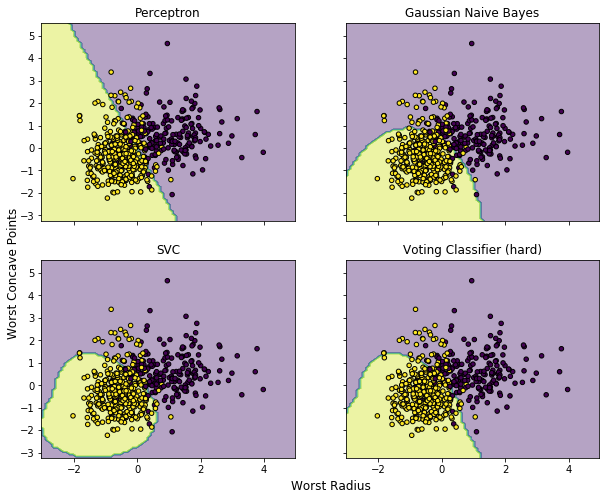

In [31]:
from itertools import product

# Plotting decision regions
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1]), all_clf, clf_labels):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(X[:, 0], X[:, 1], c=y,
                                  s=20, edgecolor='k')
    axarr[idx[0], idx[1]].set_title(tt)


plt.text(-3.5, -4.5, 
         s='Worst Radius', 
         ha='center', va='center', fontsize=12)
plt.text(-13.5, 5.0, 
         s='Worst Concave Points', 
         ha='center', va='center', 
         fontsize=12, rotation=90)

plt.show()

### 5. Check which parameters you might adapt in the voting classifier

In [32]:
#check params
clf_vc.get_params()

{'estimators': [('Perceptron',
   Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
         fit_intercept=True, max_iter=50, n_iter=None, n_iter_no_change=5,
         n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=0.001,
         validation_fraction=0.1, verbose=0, warm_start=False)),
  ('Gaussian Naive Bayes', GaussianNB(priors=None, var_smoothing=1e-09)),
  ('SVC', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
     max_iter=-1, probability=False, random_state=0, shrinking=True,
     tol=0.001, verbose=False))],
 'flatten_transform': None,
 'n_jobs': None,
 'voting': 'hard',
 'weights': None,
 'Perceptron': Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
       fit_intercept=True, max_iter=50, n_iter=None, n_iter_no_change=5,
       n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=0.001,
       validation_fraction=0.1, ve

Balanced Accuracy:

In [33]:
from sklearn.model_selection import GridSearchCV

#lets try to adapt some params:
params = {'SVC__C': [0.01, 2.0, 3.0],
         'Perceptron__alpha': [0.0001, 0.1],
         'SVC__degree': [3, 1, 2]}

grid = GridSearchCV(estimator=clf_vc, param_grid=params, cv=10, scoring='balanced_accuracy')

grid.fit(X_train, y_train)

grid_scores = zip(grid.cv_results_['params'],
                  grid.cv_results_['mean_test_score'],
                  grid.cv_results_['std_test_score'])

for params, mean_score, std_score in grid_scores:
    print("%0.3f+/-%0.2f %r"
            % (mean_score, std_score / 2, params))
print('\n Best Params for Balanced Accuracy Score:')
print(grid.best_params_)

0.923+/-0.02 {'Perceptron__alpha': 0.0001, 'SVC__C': 0.01, 'SVC__degree': 3}
0.923+/-0.02 {'Perceptron__alpha': 0.0001, 'SVC__C': 0.01, 'SVC__degree': 1}
0.923+/-0.02 {'Perceptron__alpha': 0.0001, 'SVC__C': 0.01, 'SVC__degree': 2}
0.953+/-0.01 {'Perceptron__alpha': 0.0001, 'SVC__C': 2.0, 'SVC__degree': 3}
0.953+/-0.01 {'Perceptron__alpha': 0.0001, 'SVC__C': 2.0, 'SVC__degree': 1}
0.953+/-0.01 {'Perceptron__alpha': 0.0001, 'SVC__C': 2.0, 'SVC__degree': 2}
0.956+/-0.01 {'Perceptron__alpha': 0.0001, 'SVC__C': 3.0, 'SVC__degree': 3}
0.956+/-0.01 {'Perceptron__alpha': 0.0001, 'SVC__C': 3.0, 'SVC__degree': 1}
0.956+/-0.01 {'Perceptron__alpha': 0.0001, 'SVC__C': 3.0, 'SVC__degree': 2}
0.923+/-0.02 {'Perceptron__alpha': 0.1, 'SVC__C': 0.01, 'SVC__degree': 3}
0.923+/-0.02 {'Perceptron__alpha': 0.1, 'SVC__C': 0.01, 'SVC__degree': 1}
0.923+/-0.02 {'Perceptron__alpha': 0.1, 'SVC__C': 0.01, 'SVC__degree': 2}
0.953+/-0.01 {'Perceptron__alpha': 0.1, 'SVC__C': 2.0, 'SVC__degree': 3}
0.953+/-0.01 {'Per

Accuracy:

In [34]:
#lets try to adapt some params:
params = {'SVC__C': [0.01, 2.0, 3.0],
         'Perceptron__alpha': [0.0001, 0.1],
         'SVC__degree': [3, 1, 2]}

grid = GridSearchCV(estimator=clf_vc, param_grid=params, cv=10, scoring='accuracy')

grid.fit(X_train, y_train)

grid_scores = zip(grid.cv_results_['params'],
                  grid.cv_results_['mean_test_score'],
                  grid.cv_results_['std_test_score'])

for params, mean_score, std_score in grid_scores:
    print("%0.3f+/-%0.2f %r"
            % (mean_score, std_score / 2, params))
print('\n Best Params for Accuracy Score:')
print(grid.best_params_)

0.937+/-0.01 {'Perceptron__alpha': 0.0001, 'SVC__C': 0.01, 'SVC__degree': 3}
0.937+/-0.01 {'Perceptron__alpha': 0.0001, 'SVC__C': 0.01, 'SVC__degree': 1}
0.937+/-0.01 {'Perceptron__alpha': 0.0001, 'SVC__C': 0.01, 'SVC__degree': 2}
0.955+/-0.01 {'Perceptron__alpha': 0.0001, 'SVC__C': 2.0, 'SVC__degree': 3}
0.955+/-0.01 {'Perceptron__alpha': 0.0001, 'SVC__C': 2.0, 'SVC__degree': 1}
0.955+/-0.01 {'Perceptron__alpha': 0.0001, 'SVC__C': 2.0, 'SVC__degree': 2}
0.957+/-0.01 {'Perceptron__alpha': 0.0001, 'SVC__C': 3.0, 'SVC__degree': 3}
0.957+/-0.01 {'Perceptron__alpha': 0.0001, 'SVC__C': 3.0, 'SVC__degree': 1}
0.957+/-0.01 {'Perceptron__alpha': 0.0001, 'SVC__C': 3.0, 'SVC__degree': 2}
0.937+/-0.01 {'Perceptron__alpha': 0.1, 'SVC__C': 0.01, 'SVC__degree': 3}
0.937+/-0.01 {'Perceptron__alpha': 0.1, 'SVC__C': 0.01, 'SVC__degree': 1}
0.937+/-0.01 {'Perceptron__alpha': 0.1, 'SVC__C': 0.01, 'SVC__degree': 2}
0.955+/-0.01 {'Perceptron__alpha': 0.1, 'SVC__C': 2.0, 'SVC__degree': 3}
0.955+/-0.01 {'Per

Cohens Kappa Score:

In [35]:
#lets try to adapt some params:
params = {'SVC__C': [0.01, 2.0, 3.0],
         'Perceptron__alpha': [0.0001, 0.1],
         'SVC__degree': [3, 1, 2]}

grid = GridSearchCV(estimator=clf_vc, param_grid=params, cv=10, scoring=cohen_kappa)

grid.fit(X_train, y_train)

grid_scores = zip(grid.cv_results_['params'],
                  grid.cv_results_['mean_test_score'],
                  grid.cv_results_['std_test_score'])

for params, mean_score, std_score in grid_scores:
    print("%0.3f+/-%0.2f %r"
            % (mean_score, std_score / 2, params))
print('\n Best Params for Cohens Kappa Score:')
print(grid.best_params_)

0.863+/-0.03 {'Perceptron__alpha': 0.0001, 'SVC__C': 0.01, 'SVC__degree': 3}
0.863+/-0.03 {'Perceptron__alpha': 0.0001, 'SVC__C': 0.01, 'SVC__degree': 1}
0.863+/-0.03 {'Perceptron__alpha': 0.0001, 'SVC__C': 0.01, 'SVC__degree': 2}
0.904+/-0.03 {'Perceptron__alpha': 0.0001, 'SVC__C': 2.0, 'SVC__degree': 3}
0.904+/-0.03 {'Perceptron__alpha': 0.0001, 'SVC__C': 2.0, 'SVC__degree': 1}
0.904+/-0.03 {'Perceptron__alpha': 0.0001, 'SVC__C': 2.0, 'SVC__degree': 2}
0.910+/-0.02 {'Perceptron__alpha': 0.0001, 'SVC__C': 3.0, 'SVC__degree': 3}
0.910+/-0.02 {'Perceptron__alpha': 0.0001, 'SVC__C': 3.0, 'SVC__degree': 1}
0.910+/-0.02 {'Perceptron__alpha': 0.0001, 'SVC__C': 3.0, 'SVC__degree': 2}
0.863+/-0.03 {'Perceptron__alpha': 0.1, 'SVC__C': 0.01, 'SVC__degree': 3}
0.863+/-0.03 {'Perceptron__alpha': 0.1, 'SVC__C': 0.01, 'SVC__degree': 1}
0.863+/-0.03 {'Perceptron__alpha': 0.1, 'SVC__C': 0.01, 'SVC__degree': 2}
0.904+/-0.03 {'Perceptron__alpha': 0.1, 'SVC__C': 2.0, 'SVC__degree': 3}
0.904+/-0.03 {'Per

### 6. Perform a grid search using the number of iterations for the perceptron and the support vector machine
0. Use *balanced accuracy* for scoring.
1. For the perceptron, try 5, 10, and 20 iterations
2. For the SVM, try 10, 20, and 50 iterations

In [36]:
#it is not clear from the question whether I should change param n_iter or max_iter thats why I try both param
#In the result we can see that the best param is the same for both
params = {'Perceptron__n_iter': [5, 10, 20],
          'Perceptron__max_iter': [5, 10, 20],
          'SVC__max_iter': [10, 20, 50]}

grid = GridSearchCV(estimator=clf_vc, param_grid=params, cv=10, scoring='balanced_accuracy')

grid.fit(X_train, y_train)

grid_scores = zip(grid.cv_results_['params'],
                  grid.cv_results_['mean_test_score'],
                  grid.cv_results_['std_test_score'])

for params, mean_score, std_score in grid_scores:
    print("%0.3f+/-%0.2f %r"
            % (mean_score, std_score / 2, params))

print('\n Best Params for Balanced Accuracy Score:')
print(grid.best_params_)

0.940+/-0.02 {'Perceptron__max_iter': 5, 'Perceptron__n_iter': 5, 'SVC__max_iter': 10}
0.947+/-0.01 {'Perceptron__max_iter': 5, 'Perceptron__n_iter': 5, 'SVC__max_iter': 20}
0.954+/-0.01 {'Perceptron__max_iter': 5, 'Perceptron__n_iter': 5, 'SVC__max_iter': 50}
0.940+/-0.02 {'Perceptron__max_iter': 5, 'Perceptron__n_iter': 10, 'SVC__max_iter': 10}
0.947+/-0.01 {'Perceptron__max_iter': 5, 'Perceptron__n_iter': 10, 'SVC__max_iter': 20}
0.950+/-0.01 {'Perceptron__max_iter': 5, 'Perceptron__n_iter': 10, 'SVC__max_iter': 50}
0.923+/-0.02 {'Perceptron__max_iter': 5, 'Perceptron__n_iter': 20, 'SVC__max_iter': 10}
0.938+/-0.02 {'Perceptron__max_iter': 5, 'Perceptron__n_iter': 20, 'SVC__max_iter': 20}
0.950+/-0.01 {'Perceptron__max_iter': 5, 'Perceptron__n_iter': 20, 'SVC__max_iter': 50}
0.940+/-0.02 {'Perceptron__max_iter': 10, 'Perceptron__n_iter': 5, 'SVC__max_iter': 10}
0.947+/-0.01 {'Perceptron__max_iter': 10, 'Perceptron__n_iter': 5, 'SVC__max_iter': 20}
0.954+/-0.01 {'Perceptron__max_iter

### 7. Train an Adaboost classifier with a perceptron as a base classifier as well as a random forest and compare their respective accuracies (also to the base classifier)
0. Again, use *balanced accuracy* for scoring.
1. For the perceptron, use the same parameters as above except for the maximum number of iterations which should be 5.
2. Since the perceptron does not offer class probabilities, you must specify `algorithm='SAMME'` for Adaboost. Apart from this (and the *base estimator*), you can use the parameters we employed in class.
3. For the random forest, you can use the parameters we employed in class.

In [37]:
from sklearn.ensemble import RandomForestClassifier

clf_perceptron2 = Perceptron(max_iter=5, tol=0.001, random_state=0)
forest = RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=1, n_jobs=2)

In [38]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(base_estimator=clf_perceptron2, algorithm='SAMME', n_estimators=500,
                         learning_rate=0.1,
                         random_state=0)

In [39]:
from sklearn.metrics import accuracy_score

#comparison perceptron and adaboost with perceptron as a base classifier
clf_perceptron2 = clf_perceptron2.fit(X_train, y_train)
y_train_pred = clf_perceptron2.predict(X_train)
y_test_pred = clf_perceptron2.predict(X_test)
clf_perceptron2_train = accuracy_score(y_train, y_train_pred)
clf_perceptron2_test = accuracy_score(y_test, y_test_pred)
print('Perceptron train/test accuracies %.3f/%.3f'
      % (clf_perceptron2_train, clf_perceptron2_test))

ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train, y_train_pred) 
ada_test = accuracy_score(y_test, y_test_pred) 
print('AdaBoost train/test accuracies %.3f/%.3f'
      % (ada_train, ada_test))

Perceptron train/test accuracies 0.907/0.901
AdaBoost train/test accuracies 0.957/0.936


In [43]:
ada2 = AdaBoostClassifier(base_estimator=forest, algorithm='SAMME', n_estimators=500,
                         learning_rate=0.1,
                         random_state=0)

#comparison random forrest and adaboost with random forrest as a base classifier
forest = forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)
forest_train = accuracy_score(y_train, y_train_pred) 
forest_test = accuracy_score(y_test, y_test_pred) 
print('Random forest train/test accuracies %.3f/%.3f'
      % (forest_train, forest_test))

ada2 = ada2.fit(X_train, y_train)
y_train_pred = ada2.predict(X_train)
y_test_pred = ada2.predict(X_test)
ada2_train = accuracy_score(y_train, y_train_pred) 
ada2_test = accuracy_score(y_test, y_test_pred) 
print('AdaBoost2 train/test accuracies %.3f/%.3f'
      % (ada2_train, ada2_test))

Random forest train/test accuracies 1.000/0.906
AdaBoost2 train/test accuracies 1.000/0.924


### 8.  Plot the decision regions for the classifiers you just constructed

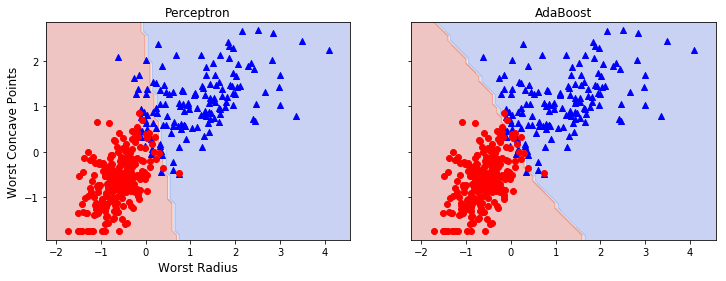

In [41]:
x_min, x_max = X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5
y_min, y_max = X_train[:, 1].min() - 0.2, X_train[:, 1].max() + 0.2
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(12, 4))


for idx, clf, tt in zip([0, 1],
                        [clf_perceptron2, ada],
                        ['Perceptron', 'AdaBoost']):
    clf.fit(X_train, y_train)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, cmap='coolwarm', alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0, 0], 
                       X_train[y_train==0, 1], 
                       c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train==1, 0], 
                       X_train[y_train==1, 1], 
                       c='red', marker='o')
    axarr[idx].set_title(tt)
    


axarr[0].set_ylabel('Worst Concave Points', fontsize=12)
axarr[0].set_xlabel('Worst Radius', fontsize=12)
    
# plt.tight_layout()
#plt.savefig('./figures/adaboost_region.png', 
#           dpi=300, 
#           bbox_inches='tight')
plt.show()

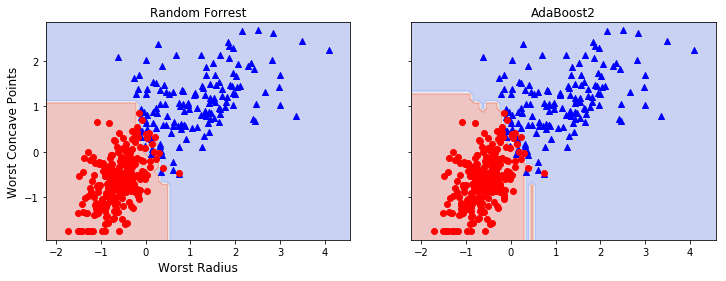

In [42]:
x_min, x_max = X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5
y_min, y_max = X_train[:, 1].min() - 0.2, X_train[:, 1].max() + 0.2
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(12, 4))


for idx, clf, tt in zip([0, 1],
                        [forest, ada2],
                        ['Random Forrest', 'AdaBoost2']):
    clf.fit(X_train, y_train)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, cmap='coolwarm', alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0, 0], 
                       X_train[y_train==0, 1], 
                       c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train==1, 0], 
                       X_train[y_train==1, 1], 
                       c='red', marker='o')
    axarr[idx].set_title(tt)
    


axarr[0].set_ylabel('Worst Concave Points', fontsize=12)
axarr[0].set_xlabel('Worst Radius', fontsize=12)

plt.show()